#### Load the Polygon of nominal water extent and define a BBOX

The BBOX defines an area of interest and will be used to create an EOPatch.

# Measuring the mean minimum distance to the shoreline of the Skagen spit system in Denmark

Notebook showcases an example Earth observation processing chain that determines mean minimum distance to the shoreline of the Skagen area from satellite imagery. The entire processing chain is performed using the `eo-learn` library.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Imports - eolearn 

In [2]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, Dependency, FeatureType

# We'll use Sentinel-2 imagery (Level 1C) provided through SentinelHub
# If you don't know what `Level 1C` means, don't worry. It doesn't matter.
from eolearn.io import S2L1CWCSInput 
from eolearn.core import LoadFromDisk, SaveToDisk

# cloud detection
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.mask import AddValidDataMaskTask

# filtering of scenes
from eolearn.features import SimpleFilterTask

# burning the vectorised polygon to raster
from eolearn.geometry import VectorToRaster

#### Imports - other 

In [3]:
# The golden standard: numpy and matplotlib
import numpy as np
#from math import sqrt, pow
from numpy import power, sqrt, array
import math

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import time

# For manipulating geo-spatial vector dataset (polygons of nominal water extent)
import geopandas as gpd
import pandas as pd
from osgeo import ogr
from osgeo import gdal, gdalconst, osr
from osgeo.gdalconst import *

# Image manipulations
# Our water detector is going to be based on a simple threshold 
# of Normalised Difference Water Index (NDWI) grayscale image
from skimage.filters import threshold_otsu

# Loading polygon of nominal water extent
from shapely.wkt import loads
from shapely.geometry import Polygon


# Sentinel Hub
from sentinelhub import BBox, CRS
from sentinelhub import geo_utils
from sentinelhub import pixel_to_utm
from sentinelhub import wgs84_to_pixel

## Water level extraction EOWorkflow

Our basic logic of the example workflow is:
1. Download all available Sentinel-2 sattelite imagery of the Skagen area from beginning of 2016 and today
    * the following *layers* will be downloaded:
        * `TRUE_COLOR` for nicer visualisations
        * `NDWI` for water detection
2. Clouds are very often obscuring the view of the ground. In order to correctly determine the water level of the dam all images with clouds need to be filtered out.
4. Apply adaptive thresholding to `NDWI` grayscale images
5. Extract water level from a comparison of measured water extent from step 4. with the nominal one

Each step in the above overview of the workflow is accomplished by adding an `EOTask` to the `EOWorkflow`

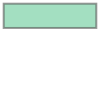

In [4]:
# The polygon of Skagen is written in wkt format (CRS=WGS84)
with open('skagen_nominal.wkt','r') as f:
    skagen_wkt = f.read()

skagen_nominal = loads(skagen_wkt)

# inflate the BBOX 
inflate_bbox = 0.1
minx, miny, maxx, maxy = skagen_nominal.bounds
delx = maxx - minx
dely = maxy - miny

minx = minx - delx * inflate_bbox
maxx = maxx + delx * inflate_bbox
miny = miny - dely * inflate_bbox
maxy = maxy + dely * inflate_bbox
    
skagen_bbox = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS.WGS84)

skagen_bbox

### Step 1: Intialize (and implement workflow specific) EOTasks

#### Create an EOPatch and add all EO features (satellite imagery data)

In [5]:
input_task = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='20m', resy='20m', maxcc=0.5, instance_id=None)
add_ndwi = S2L1CWCSInput('NDWI')

#### Burn in the nominal water extent

The `VectorToRaster` task expects the vectorised dataset in geopandas dataframe.

In [6]:
gdf = gpd.GeoDataFrame(crs={'init':'epsg:4326'},geometry=[skagen_nominal])

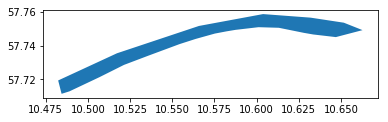

In [7]:
gdf.plot();

In [8]:
add_nominal_water = VectorToRaster((FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), gdf, 1, 
                                   (FeatureType.MASK, 'IS_DATA'), np.uint8)

#### Run s2cloudless cloud detector and filter out scenes with cloud coverage >20%

To speed up the process hte cloud detection is executed at lower resolution (160m). The resulting cloud probability map and binary mask are stored as `CLP` and `CLM` features in EOPatch.

In [9]:
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)

cloud_det = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                             cmask_feature='CLM', cprobs_feature='CLP', instance_id=None)

Define a `VALID_DATA` layer: pixel has to contain data and should be classified as clear sky by the cloud detector (`CLM` equals 0)

In [10]:
class ValidDataPredicate:
    def __call__(self, eopatch):     
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [11]:
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

Calculate fraction of valid pixels per frame and store it as `SCALAR` feature

In [12]:
def coverage(array):
    return 1.0 - np.count_nonzero(array)/np.size(array)

In [13]:
class AddValidDataCoverage(EOTask):
    def execute(self, eopatch):
        
        vld = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        
        cvrg = np.apply_along_axis(coverage, 1, np.reshape(vld, (vld.shape[0], vld.shape[1]*vld.shape[2])))
        
        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', cvrg[:,np.newaxis])
        return eopatch

In [14]:
add_coverage = AddValidDataCoverage()

Filter out too cloudy scenes

In [15]:
class ValidDataCoveragePredicate:
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = 1.0 - np.count_nonzero(array)/np.size(array)
        return coverage < self.threshold

In [16]:
remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), ValidDataCoveragePredicate(0.05))

#### Apply Water Detection



In [17]:
def water_detection(ndwi):
    """
    Very simple water detector based on Otsu thresholding method of NDWI.
    """
    otsu_thr = 1.0
    if len(np.unique(ndwi)) > 1:
        otsu_thr = threshold_otsu(ndwi)
    
    return ndwi>otsu_thr

In [18]:
class WaterDetector(EOTask):
    def execute(self, eopatch):
        water_masks = np.asarray([water_detection(ndwi[...,0]) for ndwi in eopatch.data['NDWI']])
        
        # we're only interested in the water within the dam borders
        water_masks = water_masks[...,np.newaxis] * eopatch.mask_timeless['NOMINAL_WATER']
        
        water_levels = np.asarray([np.count_nonzero(mask)/np.count_nonzero(eopatch.mask_timeless['NOMINAL_WATER']) 
                                   for mask in water_masks])
        
        eopatch.add_feature(FeatureType.MASK, 'WATER_MASK', water_masks)
        eopatch.add_feature(FeatureType.SCALAR, 'WATER_LEVEL', water_levels[...,np.newaxis])
        
        return eopatch

In [19]:
water_det = WaterDetector()

### Step 2: Define the EOWorkflow

In [20]:
workflow = LinearWorkflow(input_task, add_ndwi, cloud_det, add_nominal_water, add_valmask, add_coverage,
                          remove_cloudy_scenes, water_det)

### Step 3: Run the workflow

Process all Sentinel-2 acquisitions from beginning of 2016 and until end of August 2018.

In [21]:
time_interval = ['2016-02-01','2019-02-01']

In [22]:
result = workflow.execute({
    input_task: {
        'bbox': skagen_bbox,
        'time_interval': time_interval
    },
})

In [23]:
patch = list(result.values())[-1]

Print content of eopatch at the end of the workflow execution

In [24]:
patch

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(52, 315, 643, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(52, 315, 643, 1), dtype=float32)
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(52, 315, 643, 3), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(52, 315, 643, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(52, 315, 643, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(52, 315, 643, 1), dtype=bool)
    WATER_MASK: numpy.ndarray(shape=(52, 315, 643, 1), dtype=uint8)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(52, 1), dtype=float64)
    WATER_LEVEL: numpy.ndarray(shape=(52, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    NOMINAL_WATER: numpy.ndarray(shape=(315, 643, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_in

# Plot results

In [25]:
from skimage.filters import sobel
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from osgeo import ogr
from osgeo import gdal, gdalconst, osr
from osgeo.gdalconst import *
from sentinelhub import pixel_to_utm
from sklearn import linear_model
from scipy.stats import sem 
from scipy.optimize import fmin, root
from decimal import Decimal
from sympy import *

In [26]:
#converting pixel to meters
y_latnp = 57.7462770234641
x_lonnp = 10.6372647746451
R = 6378
arc_lon = (2*math.pi*R)/360
arc_lat = (2*math.pi*R)/360

#print(arc_lon)
#print(arc_lat)
yradians = math.radians(y_latnp)

dx_lon = arc_lon*math.cos(yradians)*1
dy_lat = arc_lat*1

#print(dy_lat)
#print(dx_lon)

#dx = 59.406... km/degree og dy = 111.317... km/degree at skagen.

x_0 = minx
y_0 = maxy #pixels starts at left top corner so y0 is the max "y" value
x_max = maxx
y_max = miny
dx = x_max-x_0
dy = y_max-y_0
x_km = dx*dx_lon
y_km = abs(dy*dy_lat)

#print(x_km,y_km)
#print(x_0,y_0)

pixel_to_m_x = x_km*1000/643
pixel_to_m_y = y_km*1000/315

print(pixel_to_m_x, pixel_to_m_y)

20.002370588282776 20.04148765903749


In [27]:
#getting coastal reference points
with open('Coastline.wkt','r') as g:
    coastline_wkt = g.read()

coastline_nominal = loads(coastline_wkt)

coast_arr = np.array(coastline_nominal)

coast_x = coast_arr[:,0]
coast_y = coast_arr[:,1]
#getting lat lon along the coast to pixel coordinates
x_0 = minx
y_0 = maxy
x_max = maxx
y_max = miny
dx = x_max-x_0
dy = y_max-y_0
percentx = (coast_x-x_0)/dx
percenty = (coast_y-y_0)/dy
coast_pixel_x = 643*percentx[::2]
coast_pixel_y = 315*percenty[::2]

coast_north_x = coast_pixel_x[0:13]
coast_north_y = coast_pixel_y[0:13]

coast_west_x = coast_pixel_x[14:57]
coast_west_y = coast_pixel_y[14:57]

In [28]:
def plot_rgb_w_water(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    matplotlib.rcParams.update({'font.size': 20}) #setting font size = 20
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    
    ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal,cmap=plt.cm.Reds)
    ax.imshow(observed,cmap=plt.cm.Blues)
    ax.axis('off')
    
    coord_obs = np.where([observed>0])
    
    xobs = coord_obs[2]
    yobs = coord_obs[1]
    
    
    for n in range(0,len(coast_north_x)):
        ax.plot(coast_north_x[n],coast_north_y[n],'cx',markersize=8)
    for k in range(0,len(coast_west_x)):
        ax.plot(coast_west_x[k],coast_west_y[k],'cx',markersize=8)
    
    fig.suptitle(eopatch.timestamp[idx])
    fig.savefig('SkagenCoast' + str(eopatch.timestamp[idx]))      

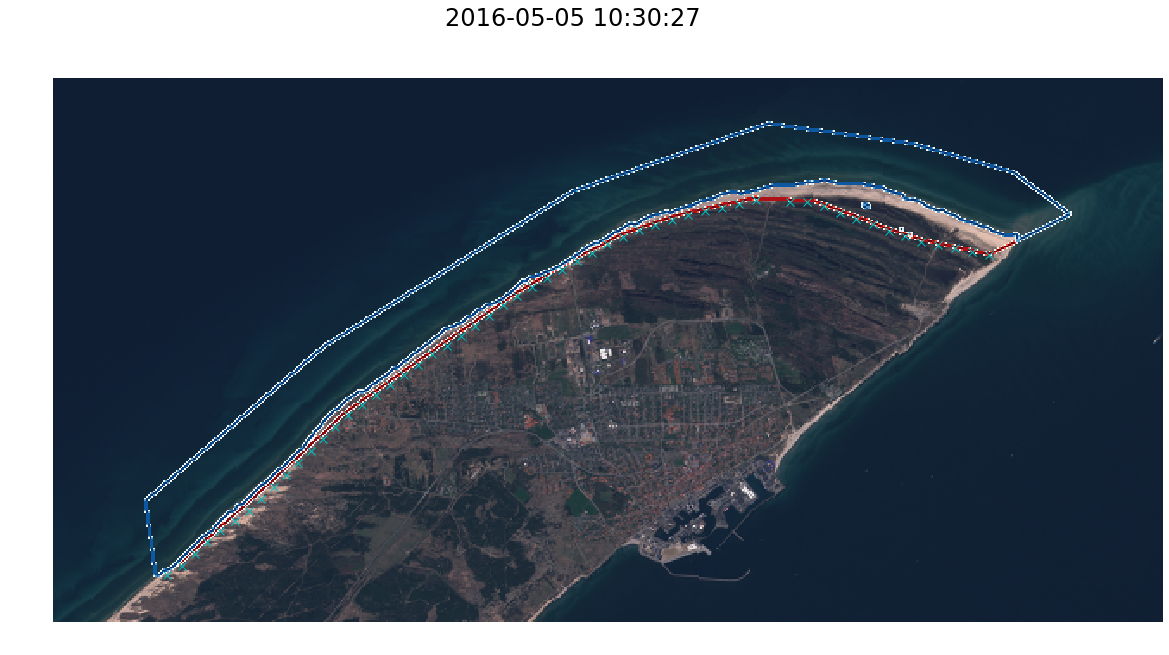

In [36]:
plot_rgb_w_water(patch, 0)

In [31]:
#def remove_water_on_land(eopatch):
    #ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    #fig, ax = plt.subplots(figsize=(ratio*10,10))
    #for i in range(0,len(eopatch.timestamp)):
        #ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][i])
        
        #observed = closing(eopatch.mask['WATER_MASK'][i,...,0], disk(1))
        #nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
        #observed = sobel(observed)
        #nominal = np.ma.masked_where(nominal == False, nominal)
        #observed = np.ma.masked_where(observed == False, observed)
       # 
        #ax.imshow(nominal,cmap=plt.cm.Reds)
        #ax.imshow(observed,cmap=plt.cm.Blues)
        #ax.axis('off')
        
        #obs_coord = np.where([observed>0])
        #print(obs_coord)
        #xobs= obs_coord[2].astype(float)
        #yobs= obs_coord[1].astype(float)
        #NaN = np.nan
        
        #sort data first:
        #sx_vec = []
        #sy_vec = []
        #dist = []
        #dist_t = []
        
        #sx0 = xobs[0]
        #sy0 = yobs[0]
        #for u in range(0,15):
            #for k in range(0,len(xobs)-1):
                #dist = np.sqrt(np.power((xobs[k+1]-sx0),2)+np.power((yobs[k+1]-sy0),2))
                #dist_t = np.append(dist_t, [dist], axis=0)
                #print(len(dist_t))
                #print((len(xobs)-1)-u)
                #if len(dist_t)==(len(xobs)-1):
                    #where_arr = np.where([dist_t==min(dist_t)])
                    #bestxy = where_arr[1]
                    #if len(where_arr[1])>1:
                        #bestxy = where_arr[1][0]
                    #dist_t = []
                    #dist = []
                    #print(bestxy)
                    #print(len(dist_t))
            #sx_vec = np.append(sx_vec, xobs[bestxy])
            #print(sx_vec)
            #sy_vec = np.append(sy_vec, yobs[bestxy])
            #sx0 = sx_vec[u]
            #print(sy_vec)
            #print(sx0)
            #sy0 = sy_vec[u]
            #xobs[bestxy] = 0
            #yobs[bestxy] = 0
        
        
        #print(xobs)
        #print(yobs)
        #print(range(len(xobs)))
        #print(len(yobs))
        
        #dist_0 = np.empty(len(xobs)).astype(int)
        #print(a)
        #n = 0
        #for n in range(0,len(xobs)-1):
            #dist_0 = np.sqrt(np.power((xobs[n+1]-xobs[n]),2)+np.power((yobs[n+1]-yobs[n]),2))
            #print(dist_0)
            #if dist_0 > 2.0:
                #xobs[n+1] = np.nan
               # yobs[n+1] = np.nan
                #n = 0
                
        #xobs_new = np.where([xobs>0])
        #yobs_new = np.where([yobs>0])
        #print(len(xobs))
        #print (xobs.ExportToWkt())
        #print (yobs.ExportToWkt())
        
                
        #ax.plot(xobs,yobs,'gp',markersize=0.3)

In [33]:
#remove_water_on_land(patch)

In [37]:
def plot_rmin_vector(eopatch, idx):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    
    ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][idx])
    
    observed = closing(eopatch.mask['WATER_MASK'][idx,...,0], disk(1))
    nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
    observed = sobel(observed)
    nominal = np.ma.masked_where(nominal == False, nominal)
    observed = np.ma.masked_where(observed == False, observed)
    
    ax.imshow(nominal,cmap=plt.cm.Reds)
    ax.imshow(observed,cmap=plt.cm.Blues)
    ax.axis('off')
    
    obs_coord = np.where([observed>0])
    
    r_distance = []
    
    xobs=obs_coord[2]
    yobs=obs_coord[1]
    
    for n in range(0,len(coast_pixel_x)):
        ax.plot(coast_pixel_x[n],coast_pixel_y[n],'cx',markersize=8)
    
    for k in range(0,len(coast_pixel_x)):
        refx1 = coast_pixel_x[k]
        refy1 = coast_pixel_y[k]
        for j in range(0,len(xobs)):
            r_vec = np.sqrt(np.power((xobs[j]-refx1),2)+np.power((yobs[j]-refy1),2))
            r_distance = np.append(r_distance, [r_vec], axis=0)
            if len(r_distance)==(len(xobs)):
                r_min = min(r_distance)
                best_xy = np.where([r_distance==r_min])
        r_distance = []
        r_min = []
        r_vec = []
        ax.plot([refx1,xobs[best_xy[1]]],[refy1,yobs[best_xy[1]]],'m-',markersize=10)
     
    fig.suptitle(eopatch.timestamp[idx])
    fig.savefig('SkagenCoastDist' + str(eopatch.timestamp[idx]))

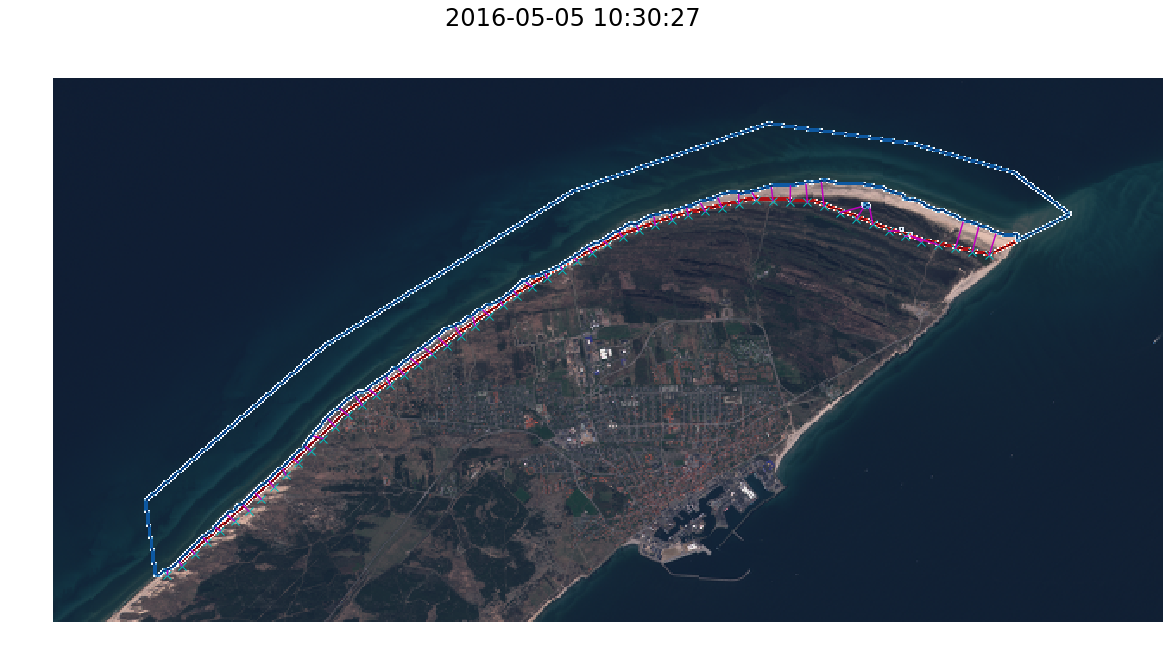

In [38]:
plot_rmin_vector(patch,0)

In [39]:
def plot_skagen_evolution_north(eopatch):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    r_evo_vec = np.empty((0,len(eopatch.timestamp)))
    for i in range(0,len(eopatch.timestamp)):
        ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][i])
        
        observed = closing(eopatch.mask['WATER_MASK'][i,...,0], disk(1))
        nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
        observed = sobel(observed)
        nominal = np.ma.masked_where(nominal == False, nominal)
        observed = np.ma.masked_where(observed == False, observed)
        
        ax.imshow(nominal,cmap=plt.cm.Reds)
        ax.imshow(observed,cmap=plt.cm.Blues)
        ax.axis('off')
        
        obs_coord = np.where([observed>0])
        
        xobs = obs_coord[2]
        yobs = obs_coord[1]
        
        r_test = np.zeros((len(coast_north_x),len(eopatch.timestamp)))
        
        for n in range(0,len(coast_north_x)):
            r_distance = np.sqrt(np.power((xobs-coast_north_x[n])*pixel_to_m_x,2)+np.power((yobs-coast_north_y[n])*pixel_to_m_y,2))
            r_result = min(r_distance)
            r_evo_vec = np.append(r_evo_vec, [r_result])
        
        for n in range(0,len(coast_north_x)):
            ax.plot(coast_north_x[n],coast_north_y[n],'cx',markersize=8)
        
        #fig.savefig('SkagenNorth' + str(i))
    
                    
    evo_true_test = np.zeros((len(coast_north_x),len(eopatch.timestamp)))
    
    for j in range(0,len(eopatch.timestamp)):
        evo_true_test[:,j] = r_evo_vec[(0+len(coast_north_x)*j):(len(coast_north_x)*(j+1))]    
    
    evo_sum = np.sum(evo_true_test, axis=0)
    
    evo_mean = evo_sum/len(coast_north_x)
    
    print(evo_mean[25])
    std_dev = np.std(evo_mean)
    std_err = sem(evo_mean)
    
    print('standard deviation for raw data = {}'.format(std_dev))
    print('standard error for raw data = {} %'.format(std_err))
    
    bad_dates = np.where(evo_mean<200)          #dates where distance < 200m
    good_dates = np.where(evo_mean>200)         #dates where distance > 200m
    
    threshold = 200
    evo_w_threshold = evo_mean[good_dates]
    y_threshold = np.zeros(len(evo_w_threshold))
    y_threshold[:] = threshold
    
    imp_std_dev = np.std(evo_w_threshold)
    imp_std_err = sem(evo_w_threshold)

    print('Improved standard deviation = {}'.format(imp_std_dev))
    print('Improved standard error = {} %'.format(imp_std_err))
    
    dates = np.asarray(eopatch.timestamp)
                       
    dt = pd.to_datetime(dates)
    
    xdates = mdates.date2num(dates[good_dates])
    
    xp = np.linspace(xdates.min(), xdates.max())
    dd = mdates.num2date(xp)
    
    xses = range(0,len(evo_w_threshold))
    xses_test = xdates.reshape((-1,1))
    
    print('idx where the mean minimum distance to the shoreline is < 200m = {}'.format(bad_dates))
    
    if len(dates) > 10:
        polynumber = 3
    else:
        polynumber = 6
    zfit = np.polyfit(xdates,evo_w_threshold,polynumber)
    p = np.poly1d(zfit)
    
    regr = linear_model.LinearRegression()
    regr.fit(xses_test,evo_w_threshold)
    
    y_predict = regr.predict(xses_test)
    
    growth_pr_yr = (regr.coef_*365)           # regr.coef_ is the regression trend pr day
    print('growth pr day = {}'.format(regr.coef_))
    print('growth pr year = {}'.format(growth_pr_yr))
    
    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle=('Plot of Skagen Evolution - North Coast')
    
    years = mdates.YearLocator()              # every year
    months = mdates.MonthLocator(interval=3)  # every 3rd month
    years_fmt = mdates.DateFormatter('%Y-%m') # format (Yr-mm)
    
    Urd = np.asarray([datetime.datetime(2016,12,26)])
    Ingolf = np.asarray([datetime.datetime(2017,10,29)])
    Johanne = np.asarray([datetime.datetime(2018,8,10)])
    Knud = np.asarray([datetime.datetime(2018,9,21)])
    Alfrida = np.asarray([datetime.datetime(2019,1,1)])
        
    yline = np.linspace(0, 500, 100)
        
    ax.plot(xp, p(xp),'-k', label='Polynomial fit in {}th order'.format(polynumber))
    ax.plot(dates[good_dates],y_threshold,linestyle=':',color='r',label='Filteret outliers below {}'.format(threshold))
    ax.plot(dates[good_dates],y_predict,'m--',label='Linear Regression = {}'.format(regr.coef_))
    ax.plot(dates[good_dates], evo_w_threshold,'bo',label='Data points')
    ax.errorbar(dates[good_dates], evo_w_threshold, yerr=imp_std_dev, fmt='bo')
    ax.errorbar(dates[bad_dates], evo_mean[bad_dates], yerr=imp_std_dev, fmt='bo')
    for l in range(0,len(yline)):
        ax.plot(Urd, yline[l], 'c.')
        ax.plot(Ingolf, yline[l], 'c.')
        ax.plot(Johanne, yline[l], 'c.')
        ax.plot(Knud, yline[l], 'c.')
        ax.plot(Alfrida, yline[l], 'c.')
    ax.set_xlim(xdates.min(), xdates.max())
    ax.set_ylim(0, 350)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(years)
    ax.set_xlabel('Date (yr-mm)')
    ax.set_ylabel('Mean minimum distance to shoreline (m)')
    ax.set_title('Skagen Evolution')
    ax.grid(axis='both')
    ax.legend()
    fig.savefig('SkagenNorthAnalysis' + str(len(eopatch.timestamp)))
    
    true_dates = np.asarray(eopatch.timestamp)
    
    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle('Plot of Skagen Evolution with Dates - North Coast')
    ax.errorbar(dates, evo_mean, yerr=imp_std_dev, fmt='bo')
    ax.set_xlim(xdates.min(), xdates.max())
    ax.set_ylim(0, 350)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(years)
    ax.set_xlabel('Date (yr-mm)')
    ax.set_ylabel('Mean minimum distance to shoreline (m)')
    ax.set_title('Skagen Evolution')
    ax.grid(axis='both')
    fig.savefig('SkagenNorthDates' + str(len(eopatch.timestamp)))

142.94629479894067
standard deviation for raw data = 46.80732179592152
standard error for raw data = 6.554336049751908 %
Improved standard deviation = 18.419903539904826
Improved standard error = 2.8090089554999693 %
idx where the mean minimum distance to the shoreline is < 200m = (array([ 1, 24, 25, 26, 27, 28, 29, 30]),)
growth pr day = [0.03841468]
growth pr year = [14.02135786]


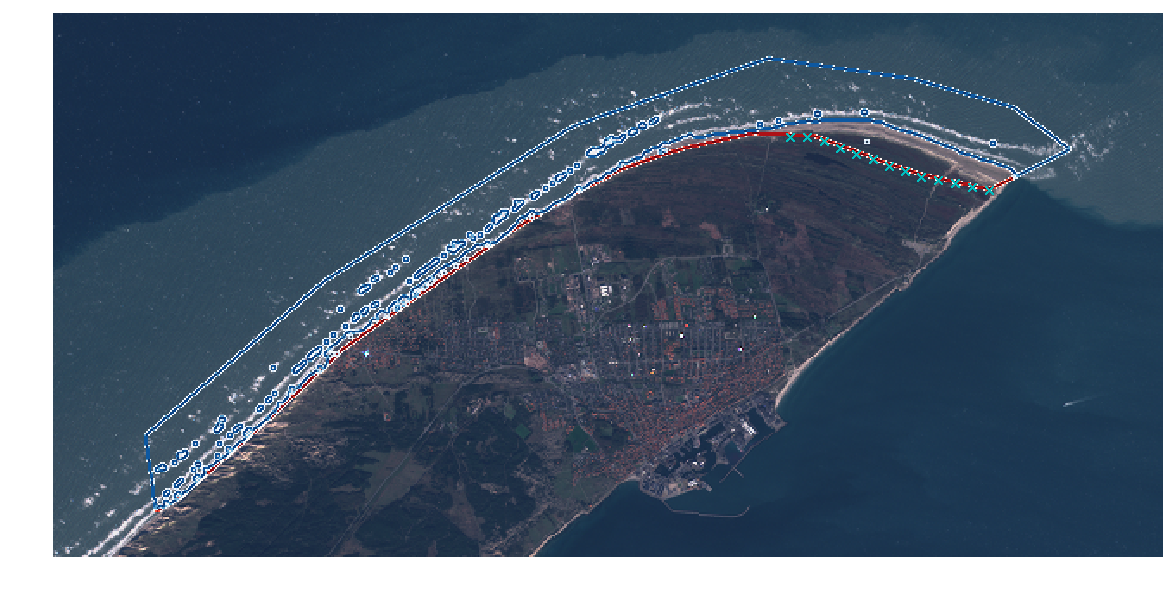

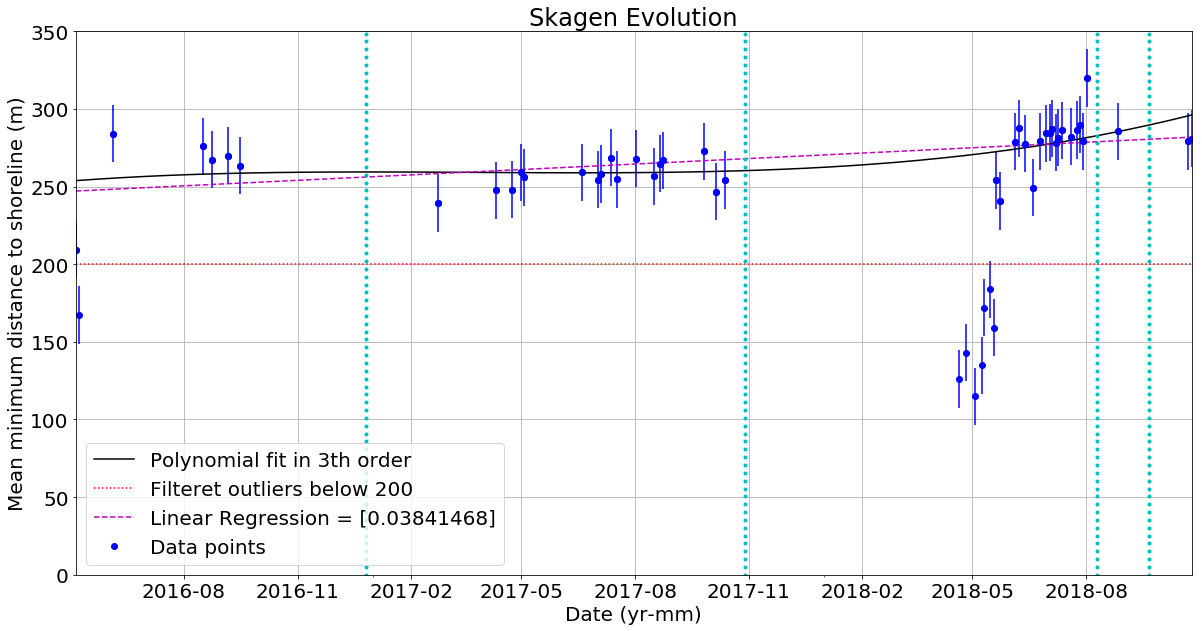

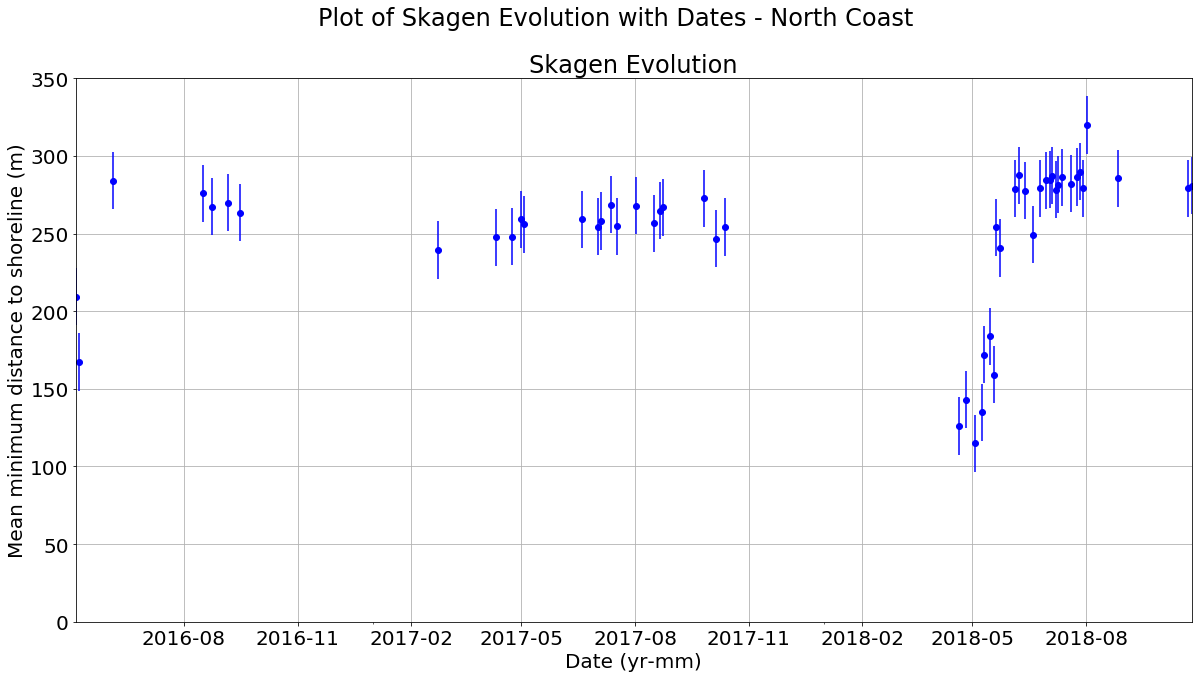

In [40]:
plot_skagen_evolution_north(patch)

Illustration of the bad dates shows clouds. The distance is therefor incorrect and in this case shorter.
The bad dates have therefor been filteret out by an appropriate threshold. Below is an illustration of a cloudy scene.

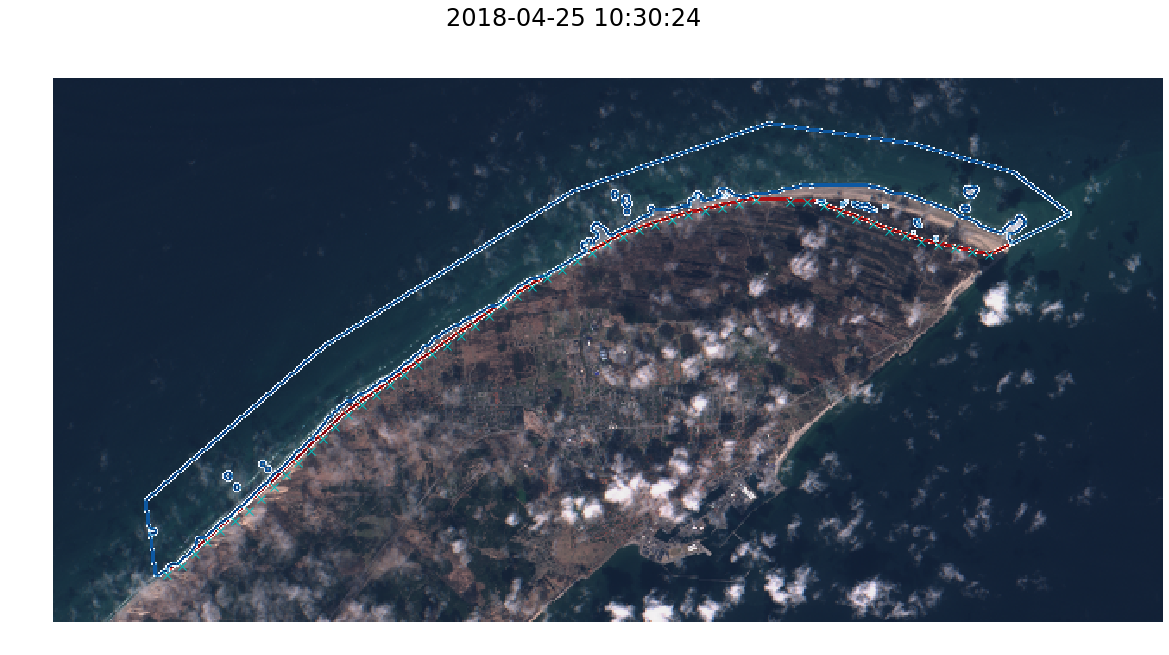

In [41]:
plot_rgb_w_water(patch, 25)

In [42]:
def plot_skagen_evolution_west(eopatch):
    ratio = np.abs(eopatch.bbox.max_x - eopatch.bbox.min_x)/np.abs(eopatch.bbox.max_y - eopatch.bbox.min_y)
    fig, ax = plt.subplots(figsize=(ratio*10,10))
    r_evo_vec = np.empty((0,len(eopatch.timestamp)))
    for i in range(0,len(eopatch.timestamp)):
        ax.imshow(eopatch.data['TRUE-COLOR-S2-L1C'][i])
        
        observed = closing(eopatch.mask['WATER_MASK'][i,...,0], disk(1))
        nominal = sobel(eopatch.mask_timeless['NOMINAL_WATER'][...,0])
        observed = sobel(observed)
        nominal = np.ma.masked_where(nominal == False, nominal)
        observed = np.ma.masked_where(observed == False, observed)
        
        ax.imshow(nominal,cmap=plt.cm.Reds)
        ax.imshow(observed,cmap=plt.cm.Blues)
        ax.axis('off')
        
        obs_coord = np.where([observed>0])
        
        xobs = obs_coord[2]
        yobs = obs_coord[1]
        
        r_test = np.zeros((len(coast_west_x),len(eopatch.timestamp)))
        
        for n in range(0,len(coast_west_x)):
            r_distance = np.sqrt(np.power((xobs-coast_west_x[n])*pixel_to_m_x,2)+np.power((yobs-coast_west_y[n])*pixel_to_m_y,2))
            r_result = min(r_distance)
            r_evo_vec = np.append(r_evo_vec, [r_result])
        
        for n in range(0,len(coast_west_x)):
            ax.plot(coast_west_x[n],coast_west_y[n],'cx',markersize=8)
        
        #fig.savefig('SkagenWest' + str(i))
    
                    
    evo_true_test = np.zeros((len(coast_west_x),len(eopatch.timestamp)))
    
    for j in range(0,len(eopatch.timestamp)):
        evo_true_test[:,j] = r_evo_vec[(0+len(coast_west_x)*j):(len(coast_west_x)*(j+1))]    
    
    evo_sum = np.sum(evo_true_test, axis=0)
    
    evo_mean = evo_sum/len(coast_west_x)
    
    std_dev = np.std(evo_mean, axis=0)
    std_err = sem(evo_mean, axis=0)
    
    print('standard deviation for raw data = {}'.format(std_dev))
    print('standard error for raw data = {} %'.format(std_err))
    
    bad_dates = np.where(evo_mean<60)        #dates where distance > 100m
    good_dates = np.where(evo_mean>60)       #dates where distance < 100m
    
    threshold = 60
    evo_w_threshold = evo_mean[good_dates]
    y_threshold = np.zeros(len(evo_w_threshold))
    y_threshold[:] = threshold
    
    imp_std_dev = np.std(evo_w_threshold)
    imp_std_err = sem(evo_w_threshold)
    
    print('Improved standard deviation = {}'.format(imp_std_dev))
    print('Improved standard error = {} %'.format(imp_std_err))
    
    dates = np.asarray(eopatch.timestamp)

    dt = pd.to_datetime(dates)
    
    xdates = mdates.date2num(dates[good_dates])
    
    xp = np.linspace(xdates.min(), xdates.max())
    dd = mdates.num2date(xp)
    
    xses = range(0,len(evo_w_threshold))
    xses_test = xdates.reshape((-1,1))
    
    print('idx of images where the distance to the shoreline is < 60m = {}'.format(bad_dates))
    
    if len(dates) > 10:
        polynumber = 3
    else:
        polynumber = 6
    zfit = np.polyfit(xdates,evo_w_threshold,polynumber)
    p = np.poly1d(zfit)
    
    regr = linear_model.LinearRegression()
    regr.fit(xses_test,evo_w_threshold)
    
    y_predict = regr.predict(xses_test)
    
    growth_pr_yr = (regr.coef_*365)           # regr.coef_ is the regression trend pr. day
    print('growth pr day = {}'.format(regr.coef_))
    print('growth pr year = {}'.format(growth_pr_yr))
    
    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle=('Plot of Skagen Evolution - West Coast')
    
    years = mdates.YearLocator()              # every year
    months = mdates.MonthLocator(interval=3)  # every 3rd month
    years_fmt = mdates.DateFormatter('%Y-%m') # format (Yr-mm)
    
    Urd = np.asarray([datetime.datetime(2016,12,26)])
    Ingolf = np.asarray([datetime.datetime(2017,10,29)])
    Johanne = np.asarray([datetime.datetime(2018,8,10)])
    Knud = np.asarray([datetime.datetime(2018,9,21)])
    Alfrida = np.asarray([datetime.datetime(2019,1,1)])
        
    yline = np.linspace(0, 500, 100)
        
    ax.plot(xp, p(xp),'-k', label='Polynomial fit in {}th order'.format(polynumber))
    ax.plot(dates[good_dates],y_threshold,linestyle=':',color='r',label='Filteret outliers below {}'.format(threshold))
    ax.plot(dates[good_dates],y_predict,'m--',label='Linear Regression = {}'.format(regr.coef_))
    ax.plot(dates[good_dates], evo_w_threshold,'bo',label='Data points')
    ax.errorbar(dates[good_dates], evo_w_threshold, yerr=imp_std_dev, fmt='bo')
    ax.errorbar(dates[bad_dates], evo_mean[bad_dates], yerr=imp_std_dev, fmt='bo')
    for l in range(0,len(yline)):
        ax.plot(Urd, yline[l], 'c.')
        ax.plot(Ingolf, yline[l], 'c.')
        ax.plot(Johanne, yline[l], 'c.')
        ax.plot(Knud, yline[l], 'c.')
        ax.plot(Alfrida, yline[l], 'c.')
    ax.set_xlim(xdates.min(), xdates.max())
    ax.set_ylim(0, 350)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(years)
    ax.set_xlabel('Date (yr-mm)')
    ax.set_ylabel('Mean minimum distance to shoreline (m)')
    ax.set_title('Skagen Evolution')
    ax.grid(axis='both')
    ax.legend()
    fig.savefig('SkagenWestAnalysis' + str(len(eopatch.timestamp)))
    
    true_dates = np.asarray(eopatch.timestamp)
    
    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle('Plot of Skagen Evolution with Dates - West Coast')
    ax.errorbar(dates, evo_mean, yerr=imp_std_dev, fmt='bo')
    ax.set_xlim(xdates.min(), xdates.max())
    ax.set_ylim(0, 350)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(years)
    ax.set_xlabel('Date (yr-mm)')
    ax.set_ylabel('Mean minimum distance to shoreline (m)')
    ax.set_title('Skagen Evolution')
    ax.grid(axis='both')
    fig.savefig('SkagenWestDates' + str(len(eopatch.timestamp)))

standard deviation for raw data = 6.8851976606889576
standard error for raw data = 0.964120515885899 %
Improved standard deviation = 5.319510532177256
Improved standard error = 0.7759303585489961 %
idx of images where the distance to the shoreline is < 60m = (array([ 3,  7, 36, 51]),)
growth pr day = [-0.00339604]
growth pr year = [-1.23955477]


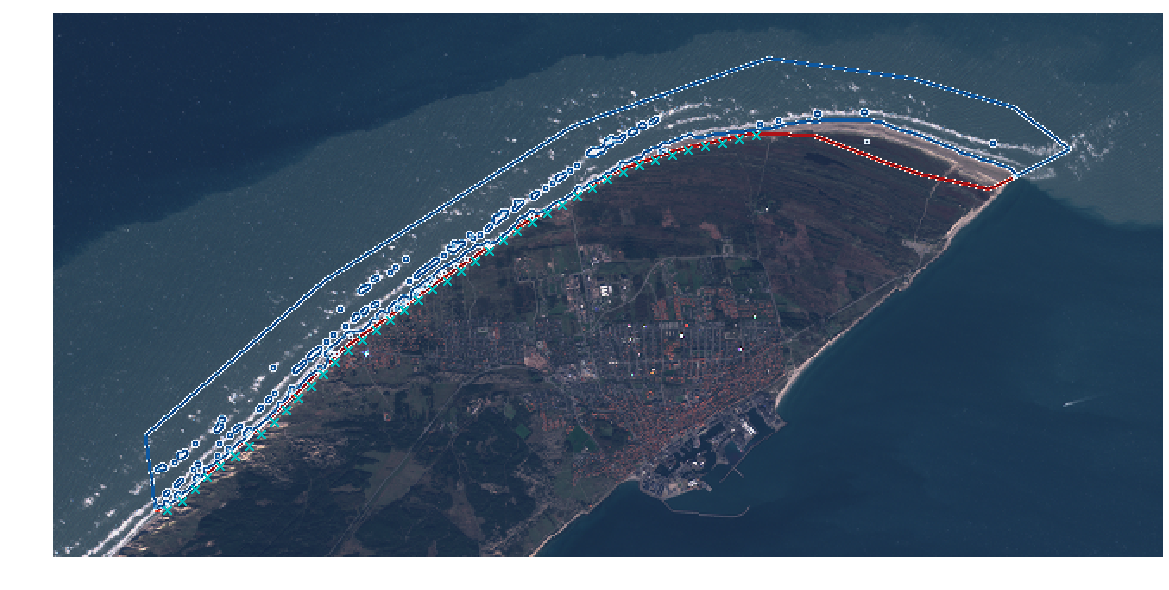

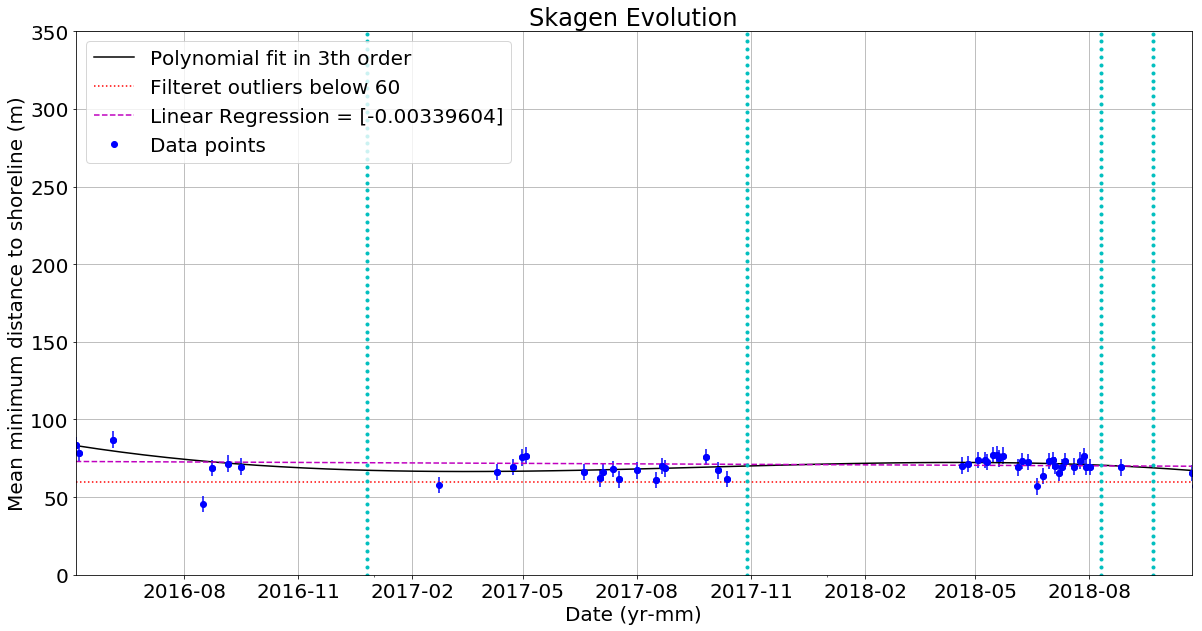

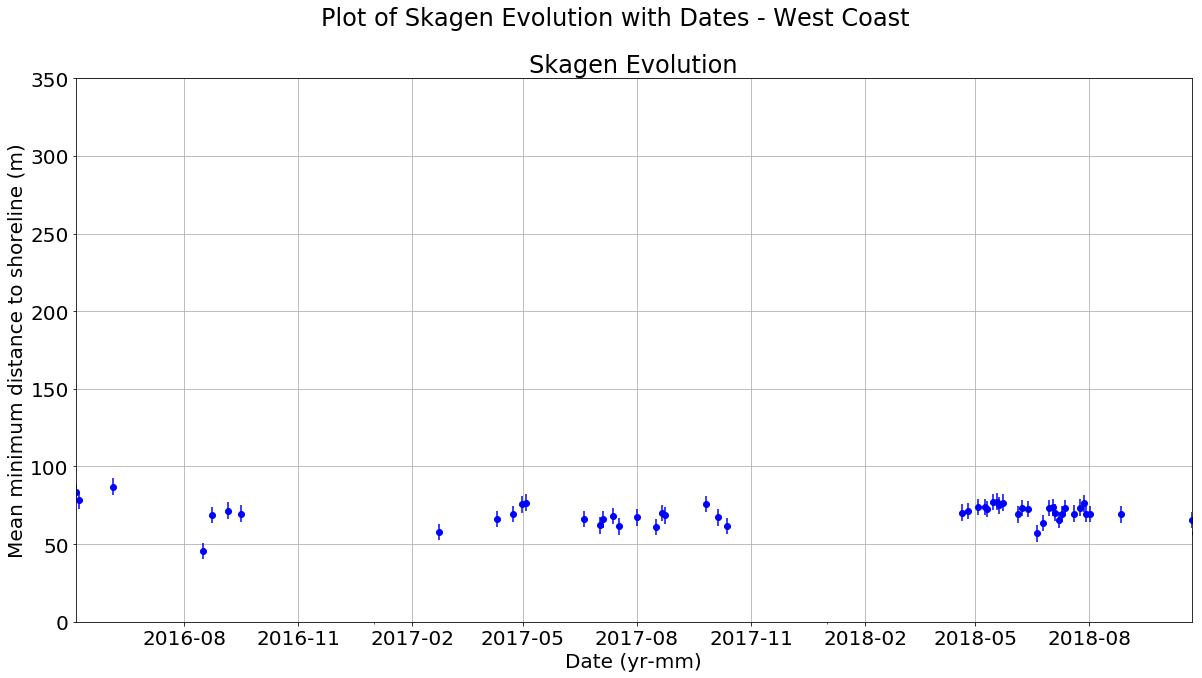

In [43]:
plot_skagen_evolution_west(patch)
